# Лабораторная работа №5. Сверточные нейронные сети

В данной лабораторной работе рассматривается решение задачи классификации посредством свёрточных нейронных сетей.
Для построения сетей предлагается использовать [Keras](https://keras.io) на базе [TensorFlow](https://www.tensorflow.org).

### import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
import sklearn as sk
import sklearn.datasets
import sklearn.model_selection

mpl.rcParams['axes.grid'] = True

print(f"tensorflow = {tf.__version__}, keras = {tf.keras.__version__}")
if tuple(map(int, tf.__version__.split('.'))) < (2, 5, 0):
    tf.autograph.set_verbosity(0)
    import logging
    logging.getLogger("tensorflow").setLevel(logging.ERROR)

## Задание №1

Загрузите датасет MNIST с помощью вызова `tf.keras.datasets.mnist.load_data()`.
Промасштабируйте обучающую и тестовую выборки, чтобы входные значения лежали в отрезке $[0; 1]$.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.float32(x_train / x_train.max()).reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
y_train = y_train.reshape(y_train.shape[0], 1)

x_test = np.float32(x_test / x_test.max()).reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

print(x_train.dtype, x_train.shape, y_train.shape)
assert x_train.dtype == np.float32 and x_test.dtype == np.float32, 'Неправильный тип входных данных'
assert x_train.shape[1:] == (28, 28, 1) and x_test.shape[1:] == (28, 28, 1), 'Неправильная размерность входных данных'
assert (x_train <= 1).all() and (x_test <= 1).all(), 'Неправильный диапазон входных данных'

float32 (60000, 28, 28, 1) (60000, 1)


Изучите приведённую ниже сеть с архитектурой:

1. Свёточный слой с 16 фильтрами размера $3\times3$ и функцией активации relu
1. Слой MaxPooling с размером шага 2
1. Свёточный слой с 32 фильтрами размера $3\times3$ и функцией активации relu
1. Слой MaxPooling с размером шага 2
1. Свёточный слой с 64 фильтрами размера $3\times3$ и функцией активации relu
1. Слой линеаризации
1. Полносвязный слой с количеством нейронов равным количеству выходных классов с функцией активации softmax

В качестве градиетного спуска выступает SGD, размер батча определяется при обучении модели.
Для вычисления функции потерь используется кросс-энтропия по категориям с автоматическим OneHot кодированием.
Метрика точности соответствует $accuracy(\tilde{y}, y) = \frac{1}{N} \sum_{n=0}^{N-1} 1(\tilde{y}_n = y_n)$.
При этом точное название метрики `sparse_categorical_accuracy`, которое можно сократить до `accuracy`, так как метрика выбирается согласно функции потерь.

Запустите нейросеть.
Итоговая точность должна получится около 92% или больше.

In [3]:
%%time

def create_model1(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model1(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=3, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

y_pred = model(x_test)
print('y_test', y_test[:2], 'y_pred', y_pred[:2])

2023-12-17 15:17:42.085961: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496 

2023-12-17 15:22:23.303364: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 501760000 exceeds 10% of free system memory.
2023-12-17 15:22:25.171297: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 501760000 exceeds 10% of free system memory.
2023-12-17 15:22:25.803121: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 501760000 exceeds 10% of free system memory.
2023-12-17 15:22:26.694794: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 250880000 exceeds 10% of free system memory.
2023-12-17 15:22:28.514672: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 250880000 exceeds 10% of free system memory.


y_test [[7]
 [2]] y_pred tf.Tensor(
[[8.8381415e-07 1.6764776e-08 4.5555835e-06 1.1448789e-04 3.4833681e-07
  1.7286922e-06 7.1072931e-10 9.9946058e-01 4.5879625e-07 4.1689508e-04]
 [2.1938040e-04 1.3004137e-03 9.9176025e-01 1.1986243e-03 5.5493995e-08
  1.9176103e-03 3.2238744e-03 6.3032496e-10 3.7973918e-04 4.8179594e-10]], shape=(2, 10), dtype=float32)
CPU times: user 20min 44s, sys: 34.5 s, total: 21min 18s
Wall time: 5min 31s


**Вопросы**:

1. Сколько всего параметров у нейронной сети?
1. Сколько всего участвует в обучении векторов из обучающей выборки?
1. Какая точность достигнута?
1. В обучающей выборке в качестве классов используются числа от 0 до 9.
Что получается на выходе у нейронной сети?
Как выходные значения нейронной сети преобразовать в номер класса?

**Ответы**:

1. Общее число параметров нейронной сети равно 54'666.
1. В обучении нейронной сети участвуют 60'000 векторов обучающей выборки.
1. Достигнутая точность составляет 0.94.
1. На выходе нейронной появляется 10-мерный вектор уверенностей того, что значение на входе относится к тому или иному классу. Конечный выбор делается по максимальной уверенности.

## Задание №2

Попробуйте увеличить точность классификации, например, добавив после каждого свёрточного слоя нормализацию (BatchNormalization) или изменив архитектуру сети.
Объясните целесообразность произведенных изменений.

In [4]:
%%time

def create_model2(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model2(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=3, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0   

In [5]:
%%time

def create_model3(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model3(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=3, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 32)       128 

**Вопросы:**

1. Почему появились необучаемые параметры (non-trainable)?
1. Распишите, какие и сколько параметров входят в BatchNormalization. Для этого воспользуйтесь переменной `layers` и методом `get_weights`.
1. Сколько параметров используется на каждом batch normalization слое?
1. Какая итоговая точность получилась? Стала ли она больше?
1. Как введение новых слоёв повлияло на вермя обучения сети?
1. Попробуйте поставить BatchNormalization слои перед/после MaxPooling. Как меняются характеристики и время обучения?

**Ответы:**

1. Необучаемые параметры появились вследствие добавления слоя нормализации, т.к. параметры этого слоя не меняются.
1. В слой нормализации входят следующие типы параметров: gamma weights, beta weights, moving_mean(non-trainable), moving_variance(non-trainable).
1. Число параметров в четыре раза превышает последнюю размерность входного вектора, которая в свою очередь равна размерности предыдущего вектора.
1. Итоговая точность составила 0.98. Прирост составил 0.04.
1. Время обучения увеличилось в 1.25 раз.
1. При нормализации до пулинга характеристики и время обучения поменялись, но незначительно.

## Задание №3

Визуализируйте результат воздействия весов последней сети с первого свёрточного слоя на одно из тестовых изображений.

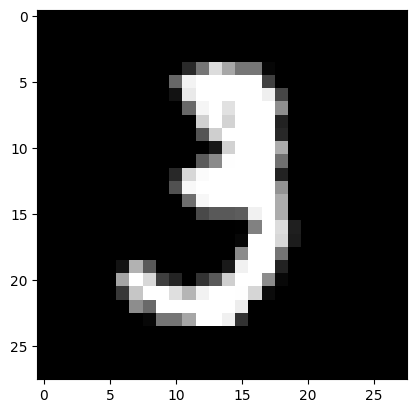

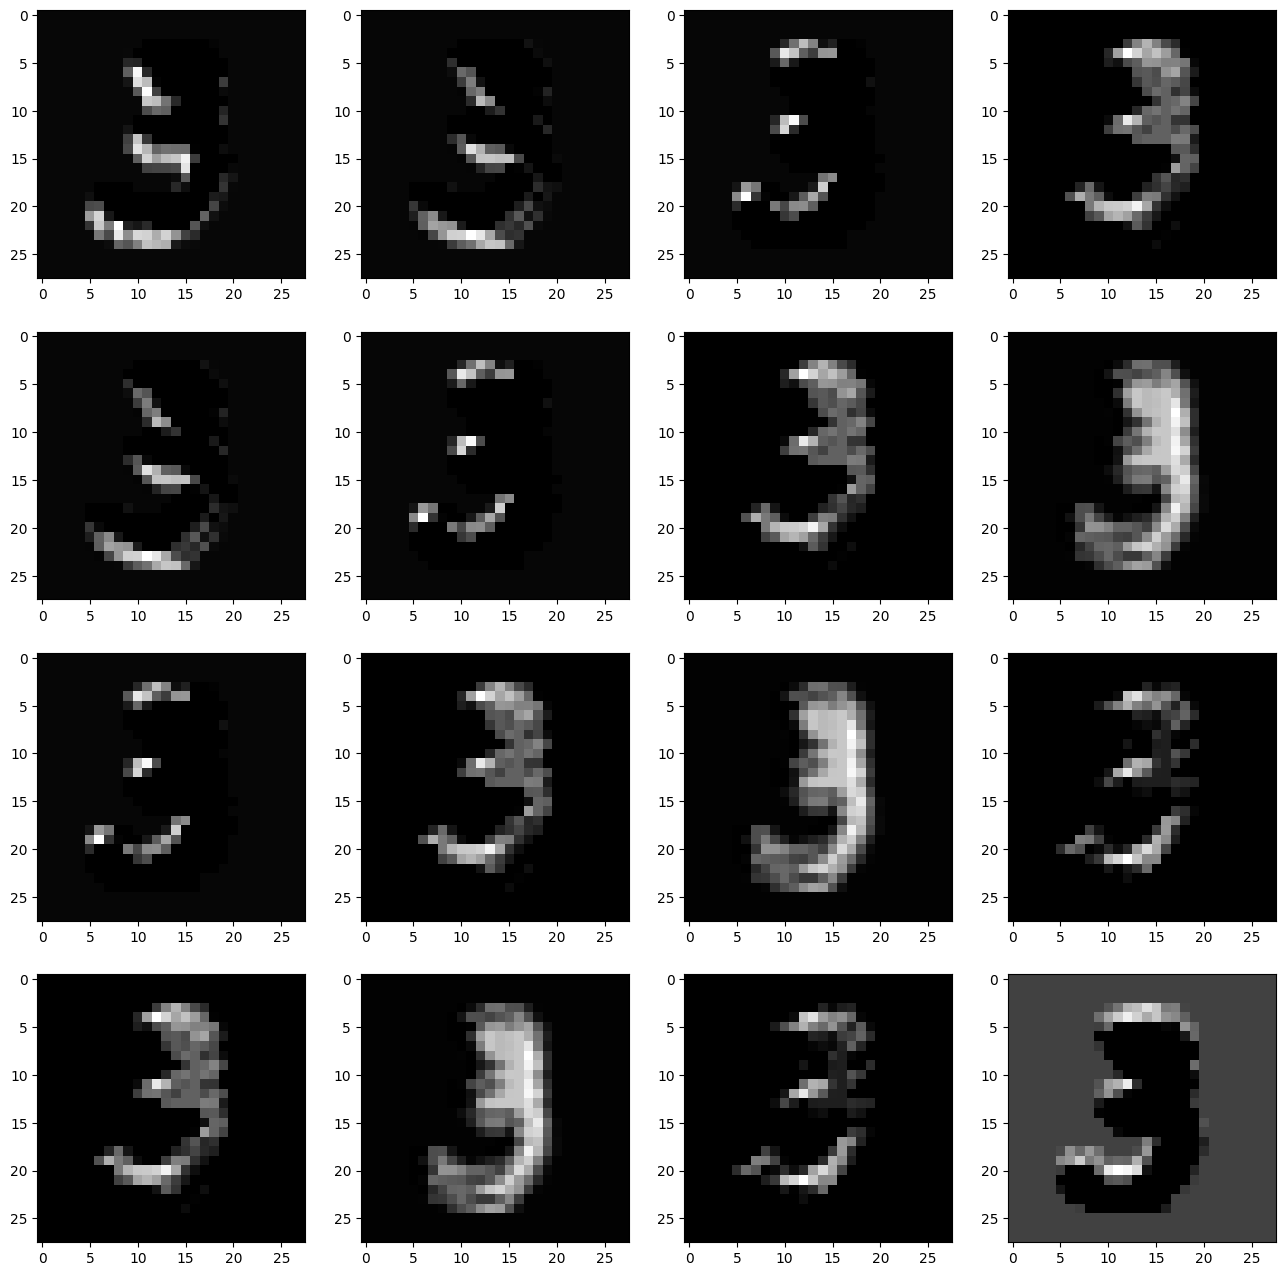

In [6]:
layer = model.get_layer(index=1)
p = layer(x_train[10:11])

plt.grid(False)
plt.imshow(x_train[10, :, :, 0], cmap='gray')

fig, axes = plt.subplots(4, 4, figsize=(4*4, 4*4))
for row, ax_rows in enumerate(axes):
    for col, ax in enumerate(ax_rows):
        ax.imshow(p[0,:,:,row+col], cmap='gray')
        ax.grid(False)

**Вопросы:**

1. На что похожи отклики с первого слоя?

**Ответы:**

1. На размытый входной вектор.

## Задание №4

Подготовьте датасет [cifar10](https://keras.io/api/datasets/) аналогично предыдущему датасету.
Во время первого запуска будет скачиваться архив (около 170 МБ).
Он будет закеширован локально, поэтому последующие загрузки этого датасета будут занимать меньше времени.

Покажите 4 произвольных изображения из обучающей выборки.

(50000, 32, 32, 3) float32 (50000, 1) uint8 (10000, 1)


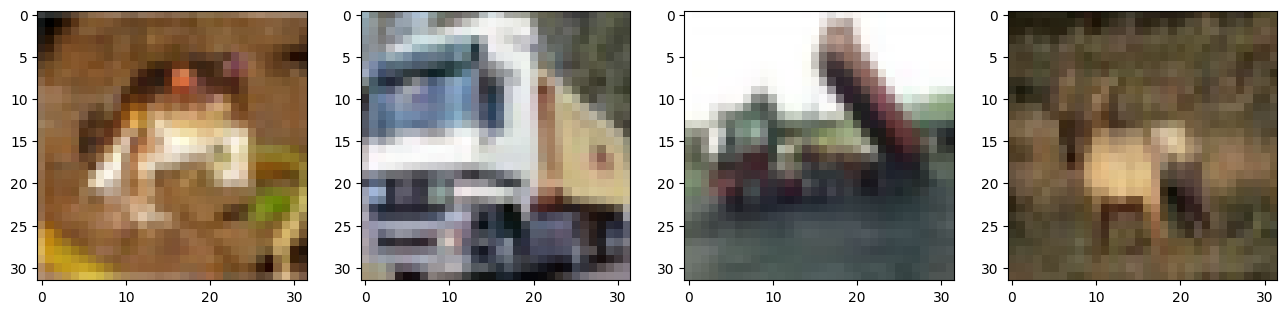

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = np.float32(x_train / x_train.max())
y_train = y_train.reshape(y_train.shape[0], 1)

x_test = np.float32(x_test / x_test.max())
y_test = y_test.reshape(y_test.shape[0], 1)

print(x_train.shape, x_train.dtype, y_train.shape, y_train.dtype, y_test.shape)

assert x_train.dtype == np.float32 and x_test.dtype == np.float32, 'Неправильный тип входных данных'
assert (x_train <= 1).all() and (x_test <= 1).all(), 'Данные не отмасштабированы'

fig, axes = plt.subplots(1, 4, figsize=(4 * 4, 4 * 4))
for k, ax in enumerate(axes):
    ax.imshow(x_train[k])
    ax.grid(False)

Постройте сеть с такой архитектурой:
```
convolution2dLayer: 32, 3x3, 'Padding'=1
reluLayer
maxPooling2dLayer: 2, 'Padding'=0

convolution2dLayer: 32, 3x3, 'Padding'=1
reluLayer
maxPooling2dLayer: 2, 'Padding'=0
       
convolution2dLayer: 64, 3, 'Padding'=1
reluLayer
maxPooling2dLayer: 2, 'Padding'=0

fullyConnectedLayer: 128
reluLayer 
fullyConnectedLayer: num_classes
softmaxLayer
```

Изображения цветные, поэтому для первого слоя с конволюцией укажите параметр `data_format='channels_last'`.
При обучении используйте 15 эпох, размер батча 128, оптимизатор градиентного спуска - SGD.
Также можно использовать любую другую архитектуру, объяснив целесообразность её применения.
Протестируйте работу данной сети.
Время обучения сети 5-10 минут.

In [8]:
%%time

def create_model4(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', data_format='channels_last')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units = 128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model4(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 64)          1849

**Вопросы:**

1. Какую точность классификации удалось получить?
1. Какие слои не имеют параметров обучения? Почему?
1. Какую размерность имеют входные изображения?

**Ответы:**

1. Достигнутая точность классификации сосставляет 0.56.
1. Параметров обучения нет у входного слоя (не требуется), слоёв пулинга (определения максимума не требует параметров) и выравнивания (не требует параметров).
1. Входные изображения имеют три канала размером 32x32.

## Задание №5

Попробуйте улучшить точность классификации, добавив нормализацию после свёрточных и полносвязных слоёв.

In [9]:
%%time

def create_model5(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', data_format='channels_last')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units = 128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model5(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 32)         0   

**Вопросы:**

1. Удалось ли увеличить точность классификации введением новых слоёв?
1. Как изменилось время обучения сети? (Обратите внимание на `Wall time`, `total`, а также на время обучения каждой эпохи)

**Ответы:**

1. Точность классификации увеличилась до 0.65.
1. Общее время обучения увеличилось на 25%, при этом время обучения некоторых эпох выросло в полтора раза, в то время как время обучения других увеличилось всего на 10%.

## Задание №6

Попробуйте добавить слой dropout `tf.keras.layers.Dropout(<probability>)` после полносвязного слоя, подобрав оптимальную на Ваш взгляд вероятность удаления нейронов.
Поэкспериментируйте с добавлением слоёв BatchNormalization и без них.

In [11]:
%%time

def create_model6(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', data_format='channels_last')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units = 128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate = 0.1)(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model6(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 16, 16, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 8, 32)         0   

**Вопросы:**

1. Удалось ли увеличить точность классификации?
1. Что влияет больше на увеличение точности: слой Dropout или BatchNormalization?
1. Как изменилось время обучения?

### **Ответы:**

1. Добавления слоя dropout не увеличило точность.
1. В проведённых опытах большее увеличение точности дала нормализация.
1. Время обучения не почти не изменилось в сравнении с оригинальной версией (до добавления нормализации или отбрасывания весов).